In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
#multi_periods = [5, 10, 25, 50, 100, 200] 
multi_periods = [5, 10, 20, 40, 80, 160]
vol_lookback = 200
smooth = int(np.ceil(periods/4))

In [3]:
contract_all = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract_all.loc['20180901': '20181231']
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180630']
#contract = contract.loc['20190101': '20190410']

In [4]:
contract_all.resample('M').last().index[3]

Timestamp('2017-03-31 00:00:00', freq='M')

In [5]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

12949.948233919557

In [50]:
vol_candles = group_by_volume(contract, avg_vol)
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)

In [7]:
time_candles = contract.resample(f'{time_int}min').agg({'open': 'first',
                               'high': 'max',
                               'low': 'min',
                               'close': 'last',
                               'volume': 'sum', 
                               'average': 'mean', 
                               'barCount': 'sum'}).reset_index()

In [8]:
def get_data(field='vol'):
    frame = globals()[f'{field}_candles']
    return frame
    return pd.DataFrame({'date': frame['date'],
                     'open': frame['open'],
                     'close': frame['close']})

In [9]:
data = get_data()
data

,date,open,high,low,close,barCount,volume
label,,,,,,,
0,2018-09-03 09:06:00,7670.00,7678.00,7658.50,7666.00,8923,12913
1,2018-09-03 15:07:00,7665.75,7680.00,7660.25,7668.00,8282,13003
2,2018-09-04 00:00:00,7668.00,7687.00,7666.50,7679.00,7543,12964
3,2018-09-04 05:14:00,7679.00,7684.25,7657.50,7673.25,9106,12997
4,2018-09-04 10:01:00,7673.00,7693.75,7669.00,7684.25,8118,12934
...,...,...,...,...,...,...,...
3602,2018-12-31 21:43:00,6322.50,6333.25,6316.25,6326.25,7139,13615
3603,2018-12-31 21:55:00,6326.25,6333.00,6302.00,6317.00,6406,11843
3604,2018-12-31 21:59:00,6316.75,6346.00,6294.75,6345.75,7283,14062


In [11]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol #data.ema_diff.ewm(span=vol_lookback).std()
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    #data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    data[f'ema_{periods}'] = data['ema_diff_norm']
    return data[f'ema_{periods}']

In [12]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [13]:
vols = vol(data, vol_lookback)

In [59]:
vols

label
0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
3602    20.764253
3603    20.654781
3604    20.834415
3605    20.771670
3606    20.663849
Name: vol_price, Length: 3607, dtype: float64

In [14]:
emas = (pd.DataFrame([ema(data, p, smooth, vols) for p in multi_periods]).T.iloc[max(multi_periods):]).reset_index(drop=True)


In [58]:
emas

,ema_5,ema_10,ema_20,ema_40,ema_80,ema_160
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3442,-0.106522,-0.102587,0.770252,2.608366,2.109801,-3.523327
3443,-0.160687,-0.139094,0.719040,2.568997,2.120300,-3.501996
3444,0.103824,-0.001698,0.748823,2.539966,2.123555,-3.421214
3445,0.339004,0.150877,0.805878,2.552325,2.157133,-3.378088


In [15]:
emas_adjustments = 10/emas.abs().mean()
emas_adjustments

ema_5      10.608442
ema_10      7.587018
ema_20      5.271691
ema_40      3.764452
ema_80      2.850397
ema_160     2.419842
dtype: float64

In [16]:
scaled_emas = (emas * emas_adjustments).clip(lower=-20, upper=20)

In [17]:
scaled_emas.abs().mean()

ema_5      9.403053
ema_10     9.382994
ema_20     9.548220
ema_40     9.756560
ema_80     9.748246
ema_160    9.660216
dtype: float64

In [18]:
target_vol = scaled_emas.abs().std().mean()
target_vol

6.191825282899992

In [19]:
corr = scaled_emas.corr()
corr

,ema_5,ema_10,ema_20,ema_40,ema_80,ema_160
ema_5,1.000000,0.852195,0.544688,0.271492,0.077784,-0.055458
ema_10,0.852195,1.000000,0.854034,0.550732,0.250987,0.012018
ema_20,0.544688,0.854034,1.000000,0.859945,0.537963,0.179251
ema_40,0.271492,0.550732,0.859945,1.000000,0.850270,0.475641
ema_80,0.077784,0.250987,0.537963,0.850270,1.000000,0.827815
ema_160,-0.055458,0.012018,0.179251,0.475641,0.827815,1.000000


In [20]:
weights = (1/corr.mean()) / (1/corr.mean()).sum()
weights

ema_5      0.201021
ema_10     0.153662
ema_20     0.136042
ema_40     0.134949
ema_80     0.152585
ema_160    0.221741
dtype: float64

In [21]:
scaled_emas.corr().mean().mean()

0.5605198174794

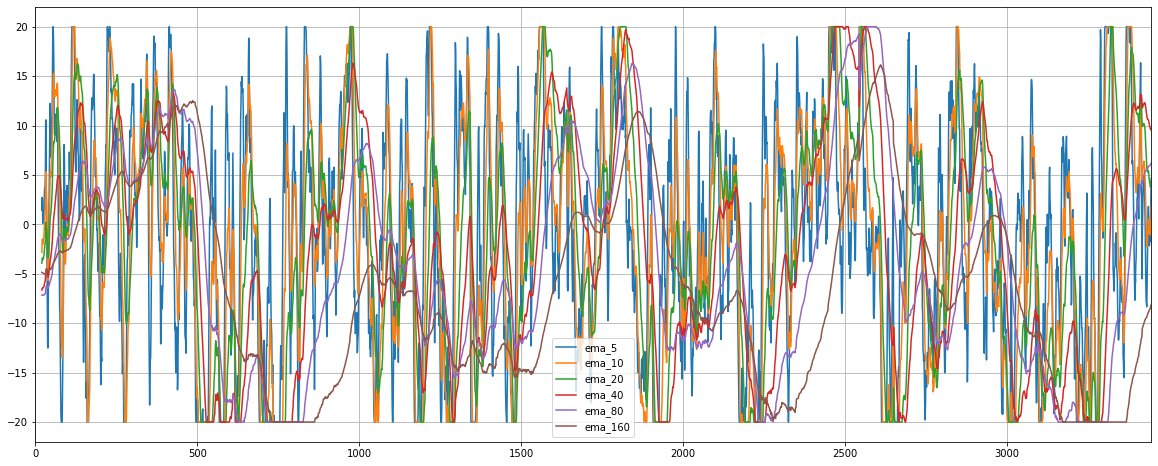

In [22]:
scaled_emas.plot(figsize=(20,8), grid=True);

In [23]:
scaled_emas

,ema_5,ema_10,ema_20,ema_40,ema_80,ema_160
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3442,-1.130029,-0.778328,4.060531,9.819068,6.013769,-8.525894
3443,-1.704639,-1.055311,3.790559,9.670867,6.043697,-8.474277
3444,1.101406,-0.012884,3.947563,9.561580,6.052973,-8.278798
3445,3.596301,1.144710,4.248340,9.608105,6.148684,-8.174438


In [24]:
scaled_emas_combined = (scaled_emas * weights).sum(axis=1)

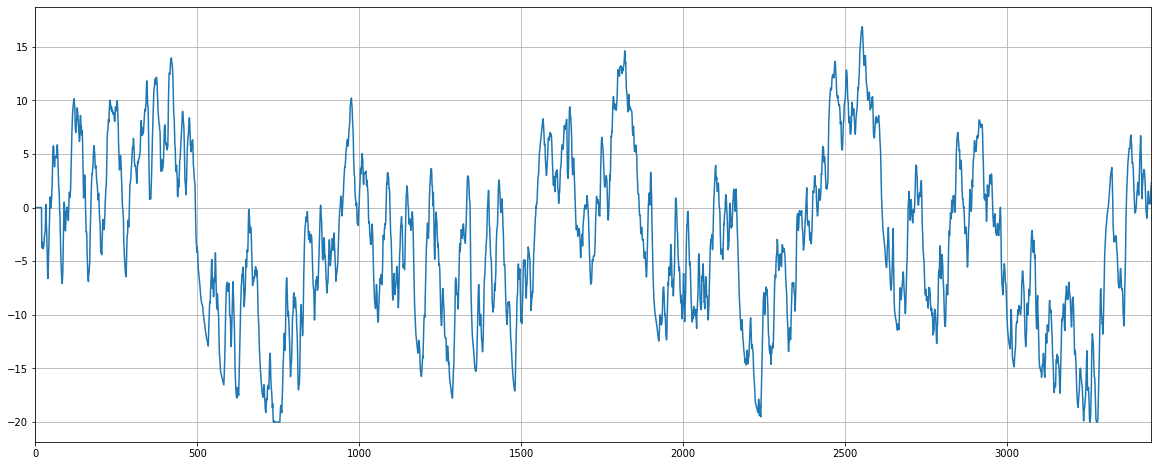

In [25]:
scaled_emas_combined.plot(figsize=(20,8), grid=True);

In [26]:
scaled_emas_combined.abs().mean()

6.88447358340352

In [27]:
scaled_emas_combined.abs().std()

4.842800417353017

In [28]:
multiplier = target_vol/scaled_emas_combined.abs().std()
multiplier

1.2785629696225076

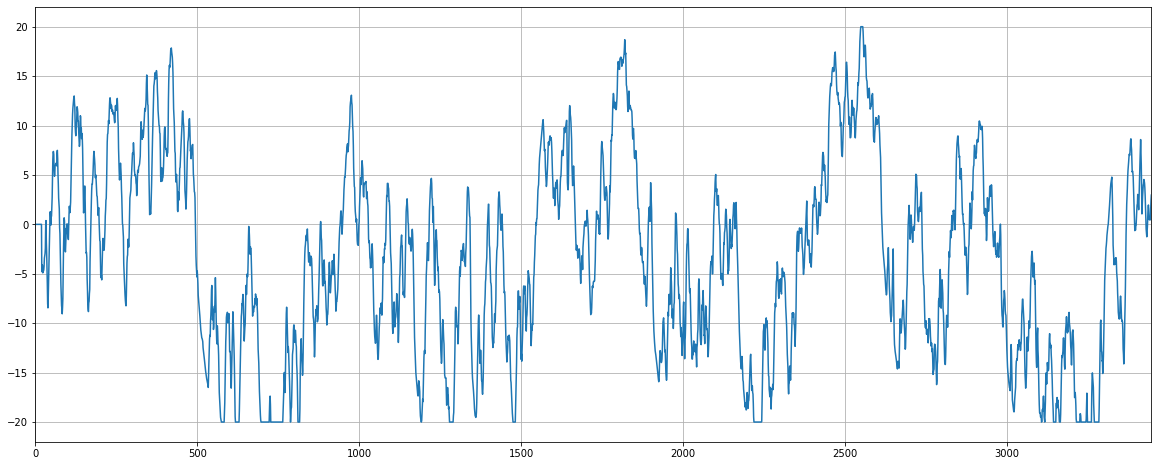

In [29]:
ema_forecast = (multiplier*scaled_emas_combined).clip(lower=-20, upper=20)
ema_forecast.plot(figsize=(20,8), grid=True);

In [30]:
ema_forecast.abs().mean(), ema_forecast.abs().std()

(8.642853485781867, 5.842960713427624)

In [31]:
contract_oos = contract_all.loc['20190101': '20191231']

In [32]:
vol_candles_oos = group_by_volume(contract_oos, avg_vol)
#vol_candles_oos['atr'] = get_ATR(vol_candles_oos, atr_periods)
data_oos = pd.DataFrame({'date': vol_candles_oos.date,
                     'open': vol_candles_oos.open,
                     'close': vol_candles_oos.close})
vols_oos = vol(data_oos, vol_lookback)
emas_oos = pd.DataFrame([ema(data_oos, p, smooth, vols_oos) for p in multi_periods]).T
scaled_emas_oos = (emas_oos * emas_adjustments).clip(lower=-20, upper=20)
scaled_emas_combined_oos = (scaled_emas_oos * weights).sum(axis=1)
ema_forecast_oos = (multiplier*scaled_emas_combined_oos).clip(lower=-20, upper=20)

In [54]:
weights

ema_5      0.201021
ema_10     0.153662
ema_20     0.136042
ema_40     0.134949
ema_80     0.152585
ema_160    0.221741
dtype: float64

In [55]:
emas_adjustments

ema_5      10.608442
ema_10      7.587018
ema_20      5.271691
ema_40      3.764452
ema_80      2.850397
ema_160     2.419842
dtype: float64

In [56]:
multiplier

1.2785629696225076

In [33]:
scaled_emas_oos.abs().mean()

ema_5       9.234063
ema_10      9.495391
ema_20      9.347459
ema_40      9.732289
ema_80     10.985165
ema_160    13.908483
dtype: float64

In [34]:
scaled_emas_oos.abs().std()

ema_5      6.278437
ema_10     6.368101
ema_20     6.265070
ema_40     5.950698
ema_80     6.357222
ema_160    6.263266
dtype: float64

In [35]:
scaled_emas_oos.corr()

,ema_5,ema_10,ema_20,ema_40,ema_80,ema_160
ema_5,1.000000,0.858394,0.557644,0.279222,0.125926,0.072460
ema_10,0.858394,1.000000,0.857903,0.548087,0.285636,0.152159
ema_20,0.557644,0.857903,1.000000,0.850839,0.545806,0.305841
ema_40,0.279222,0.548087,0.850839,1.000000,0.855091,0.572731
ema_80,0.125926,0.285636,0.545806,0.855091,1.000000,0.864494
ema_160,0.072460,0.152159,0.305841,0.572731,0.864494,1.000000


In [36]:
ema_forecast_oos.abs().mean(), ema_forecast_oos.std()

(9.78339473402206, 10.714733471598993)

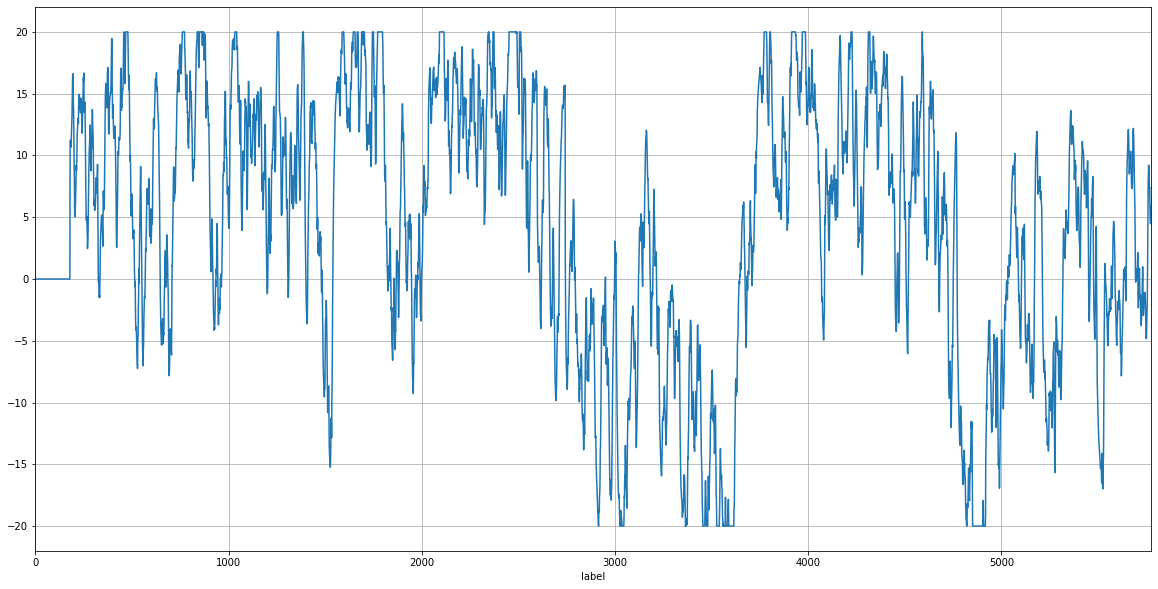

In [37]:
ema_forecast_oos.plot(figsize=(20,10), grid=True);

In [38]:
data = vol_candles_oos.copy().iloc[int(max(multi_periods)*.9):]
data['ema'] = ema_forecast_oos
data.set_index('date', inplace=True)

In [51]:
data

,open,high,low,close,barCount,volume,ema
date,,,,,,,
2019-01-04 21:48:00,6422.00,6435.50,6412.75,6433.75,7345,13298,0.000000
2019-01-04 21:57:00,6433.50,6437.50,6422.50,6433.25,6134,12300,0.000000
2019-01-04 21:59:00,6433.25,6437.75,6430.50,6436.50,5146,12055,0.000000
2019-01-04 22:59:00,6436.50,6442.75,6424.25,6431.75,7785,17606,0.000000
2019-01-07 01:33:00,6451.25,6495.50,6439.75,6490.50,9095,13353,0.000000
...,...,...,...,...,...,...,...
2019-09-04 16:59:00,7679.25,7683.75,7673.00,7682.00,6903,13405,4.470527
2019-09-04 17:24:00,7682.00,7688.50,7679.50,7686.00,6961,14187,4.591718
2019-09-04 17:41:00,7686.00,7702.75,7683.75,7700.00,6131,12957,5.375489


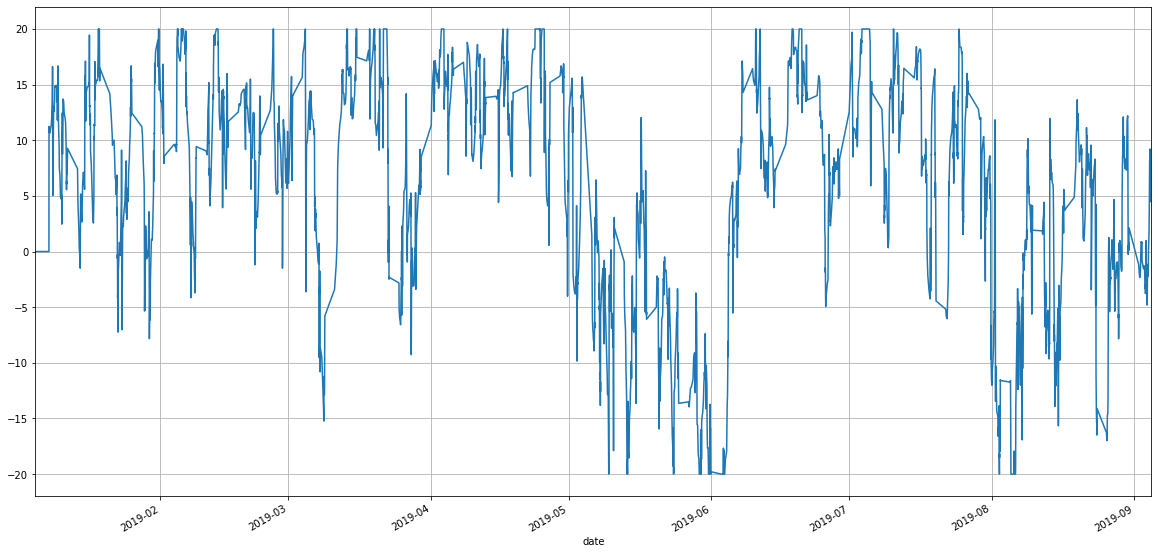

In [53]:
data.ema.plot(figsize=(20,10), grid=True);

In [39]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 5, 6, 7, 10, 15, 17]: #12, 15, 20]:
    b = v_backtester(data.open, data.ema, i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [40]:
stats

,0,5,6,7,10,15,17
Annual return,0.207042,0.198917,0.140114,0.0914825,0.0980523,-0.0342374,0.0429929
Cumulative returns,0.139598,0.134265,0.0953363,0.0626752,0.067113,-0.0239022,0.0296637
Annual volatility,0.155552,0.137973,0.139219,0.135252,0.116575,0.0874881,0.0583074
Sharpe ratio,1.2875,1.38379,1.01114,0.714313,0.860225,-0.354866,0.75072
Calmar ratio,2.05883,2.92252,2.20702,1.31123,1.39027,-0.611571,1.67532
Stability,0.870029,0.861645,0.837214,0.727971,0.704616,0.00153713,0.598619
Max drawdown,-0.100563,-0.0680633,-0.0634857,-0.0697682,-0.0705276,-0.0559827,-0.0256626
Omega ratio,1.23397,1.26373,1.18568,1.12605,1.17541,0.913541,1.26409
Sortino ratio,1.89686,2.20771,1.60458,1.13862,1.43499,-0.557821,1.69105
Skew,-0.0985697,0.305859,0.426531,0.616952,0.873556,1.30264,3.75103


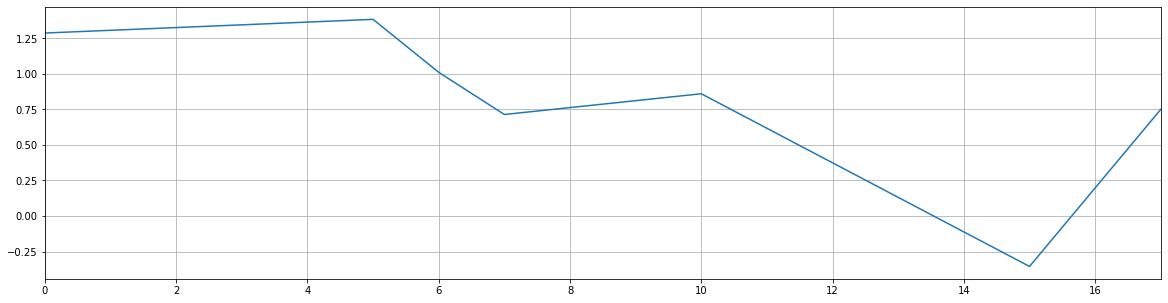

In [41]:
stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [42]:
returns.corr()

,0,5,6,7,10,15,17
0,1.000000,0.833050,0.797082,0.764793,0.697730,0.477444,0.429625
5,0.833050,1.000000,0.948051,0.920944,0.830872,0.591113,0.465371
6,0.797082,0.948051,1.000000,0.957311,0.852776,0.633165,0.480998
7,0.764793,0.920944,0.957311,1.000000,0.883576,0.637407,0.499334
10,0.697730,0.830872,0.852776,0.883576,1.000000,0.751722,0.572810
15,0.477444,0.591113,0.633165,0.637407,0.751722,1.000000,0.700090
17,0.429625,0.465371,0.480998,0.499334,0.572810,0.700090,1.000000


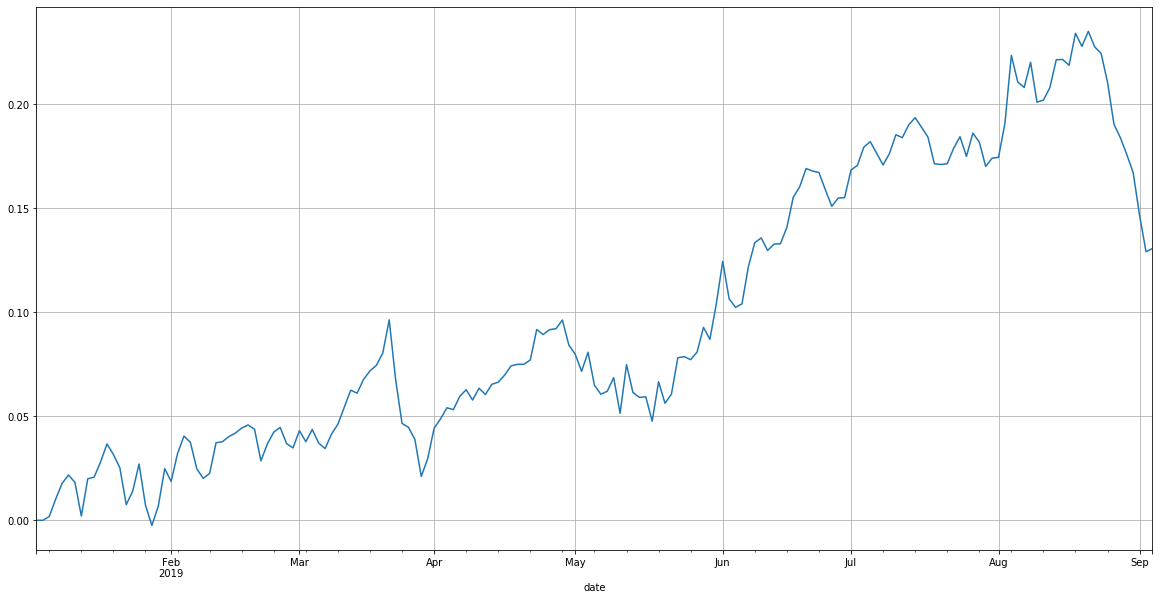

In [43]:
np.log(returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

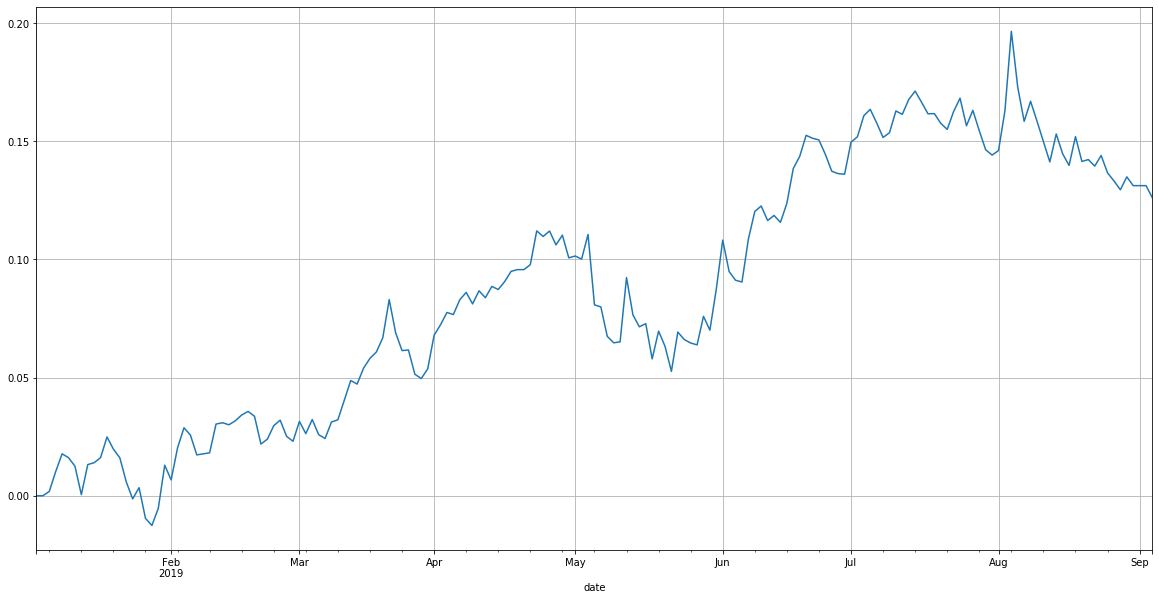

In [44]:
np.log(returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

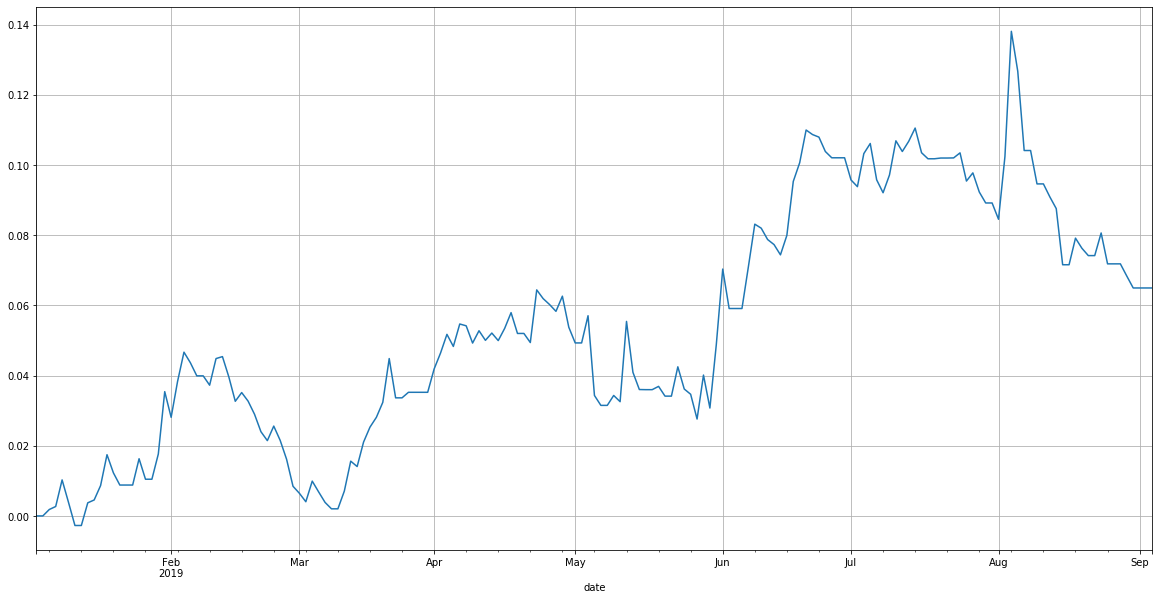

In [45]:
np.log(returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);